<a href="https://colab.research.google.com/github/Pradeepjha88/Cardiac_attack_prediction/blob/master/S12c_multiple_hidden_layer_adam_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 12c

## Multiple Hidden layers with ADAM
</p><img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

# Story So Far 

    
|#|Sheet #|Dataset|Implementation|Training Accuracy|Testing Accuracy|Remarks|
|:-:|:-:|:-:|:--|---|---|:--|
|1|S04a|make_moons|Simple Perceptron|0.84111|0.89000||
|2|S04b|make_moons|Perceptron including Softmax and Gradient Descent|0.86555|0.90000|Training Accuracy catching up|
|3|S06a|make_moons|One hidden layer with ${Tanh}$ activation|0.96875|0.96094| Better, non-linearity helps|
|4|S06b|make_moons|One hidden layer with ${ReLU}$ activation|0.96387|0.96875| Still better, Taking little longer to converge|
|5|S06c|make_moons|One hidden layer with ${Swish}$ activation|0.96680|0.96094| Similar results, Taking even longer to converge|
|6|S06d|make_circles|One hidden layer with ${Tanh}$ activation|0.83643|0.82715| Different dataset|
|7|S06e|make_circles|One hidden layer with ${ReLU}$ activation|0.83130|0.82910| Better than $Tanh$|
|8|S06f|make_circles|One hidden layer with ${Swish}$ activation|0.83471|0.83301| Better than other two|
|9|S07a|make_circles|Multiple Hidden Layers|0.96875|0.96094|Similar results.|
|10|S08a|make_circles|Multiple Hidden Layers L1 regularization|0.97070|0.96094|Similar results.|
|11|S12a|make_circles|Multiple Hidden Layers L2 regularization|0.97070|0.96094|Similar results.|

In [ ]:
# Lets import some libraries
import os

import numpy as np

#import cupy as cp

import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

In [ ]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 50000 # number of cycles to run

ALPHA = 0.1 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg
plt.rcParams.update(params) # update rcParams

## Generate Data Set
<p style="font-family: Arial; font-size:1.2em;color:black;">
Lets use Sklearn's dataset generator. To keep the example simple, lets use  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</p>

In [ ]:
X, y = datasets.make_moons(n_samples=1280, shuffle=True, noise=0.2, random_state=RANDOM_STATE)

<p style="font-family: Arial; font-size:1.1em;color:black;">
<strong>Note</strong>: All two dimentional matrix are represented by Caps and all arrays (vectors) are represented by small case.
</p>

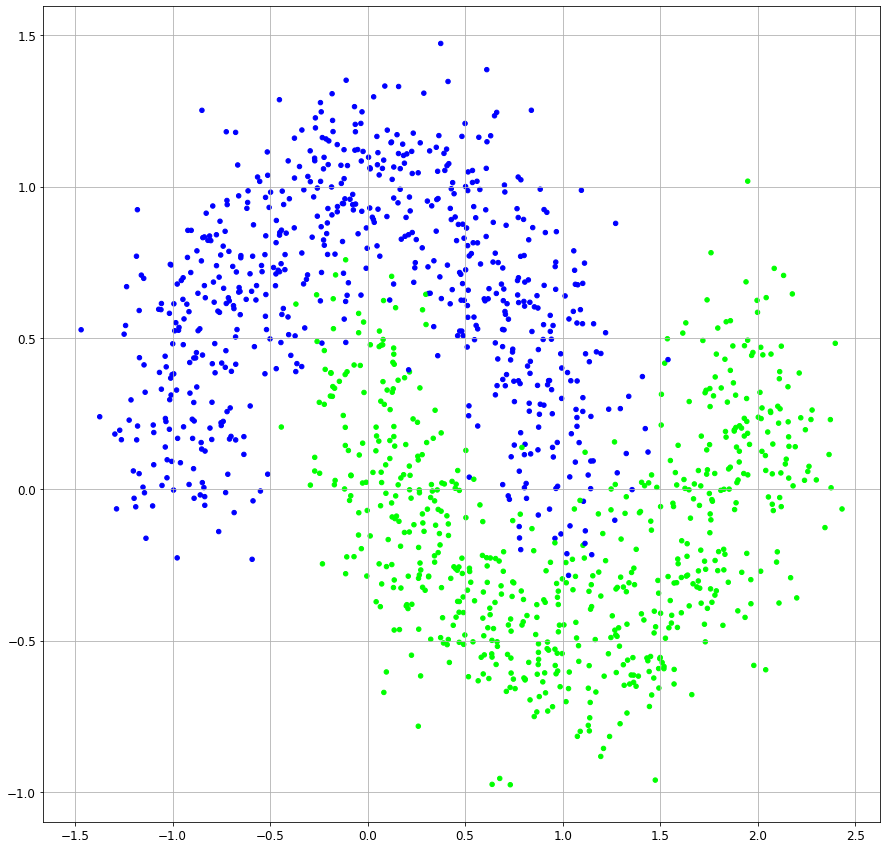

In [ ]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=CMAP)

plt.grid()

In [ ]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Attribite
           pred_func : function based on predict method of the classifier
       
       Return:
           None           
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=CMAP, edgecolors='black')

In [ ]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024,) (256, 2) (256,)


# ADAM


<img src='images/adam_algorithm.jpg' style='width: 800px'/>

<img src='images/gradient_descent_3d.png' style='width: 450px' align= 'left'/>
<img src='images/gradient_descent_contour_plot.jpg' style='width: 450px' align= 'right'/>

In [ ]:
def adam_optimizer(dW, m_t, v_t, t):
    '''
    Adam optimizer function. Note loop in in the main code.
    Args: 
        dW: Delta weight to be optimised
        m_t : 1st Moment vector of shape same as Weight
        v_t : 2nd moment vector of shape same as Weight
        t : time step
    Returns:
        updated dW
    '''
    t = t+1 # first epoch t = 0 => for t = 0 both m_cap and v_cap will be infinite
    
    m_t = beta_1*m_t + (1-beta_1)*dW      #updates the moving averages of the gradient
    
    v_t = beta_2*v_t + (1-beta_2)*(dW*dW) #updates the moving averages of the squared gradient
    
    m_cap = m_t/(1-(beta_1)**t)              #calculates the bias-corrected estimate

    v_cap = v_t/(1-(beta_2)**t)              #calculates the bias-corrected estimates
    
    # change = (alpha*m_cap)/(np.sqrt(v_cap)+adam_epsilon)
    
    return (alpha * m_cap ) / ( np.sqrt ( v_cap ) + adam_epsilon )

In [ ]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X, y):
    m = X.shape[0]
    
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    # Layer 1
    Z1 = X.dot(W1) + b1 
    A1 = np.tanh(Z1)    # tanh activation
    assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"

    # Layer 2
    Z2 = A1.dot(W2) + b2 
    A2 = np.tanh(Z2)    # tanh activation
    assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"

    # Layer 3
    Z3 = A2.dot(W3) + b3 
    A3 = np.tanh(Z3)    # tanh activation
    assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

    # Layer 4
    Z4 = A3.dot(W4) + b4 
    A4 = np.tanh(Z4)    # tanh activation
    assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"


    Z5 = A4.dot(W5) + b5
    exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
       
    # Calculating the loss
    # Cross entropy = ground truth x log (predicted)
    # probability of y being correct is 1. hence it will be a vector of [1,1,...,1,1]
    # correct_logprobs = -( y * np.log(probs) + (1-y) * np.log (1-probs)) 
    correct_logprobs = -np.log(probs[range(m), y]) 
    data_loss = np.sum(correct_logprobs)
    
    return 1./m * data_loss

In [ ]:
# Helper function to predict an output (0 or 1)

def predict(model, x):
    '''
     Args:
         model
         x: input features
    '''
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    Z1 = x.dot(W1) + b1 
    A1 = np.tanh(Z1)    # tanh activation
    assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"

    # Layer 2
    Z2 = A1.dot(W2) + b2 
    A2 = np.tanh(Z2)    # tanh activation
    assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"

    # Layer 3
    Z3 = A2.dot(W3) + b3 
    A3 = np.tanh(Z3)    # tanh activation
    assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

    # Layer 4
    Z4 = A3.dot(W4) + b4 
    A4 = np.tanh(Z4)    # tanh activation
    assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"


    Z5 = A4.dot(W5) + b5
    
    # use softmax
    exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
    
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    #*************************************    
    return np.argmax(probs, axis=1) # pick with one with highest probabilities

In [ ]:
# prepare the Model

def build_model(param, X, y, X_t, y_t, 
                num_passes=20000,
                print_loss=False):
    
    '''
        nn_hdim : Number of nodes in the hidden layer
        X   : Features to train on
        y   : Targets to train on
        X_t : Features to test
        y_t : Targets to test
        num_passes : Number of passes through the training data for gradient descent
        print_loss : If True, print the loss every 1000 iterations
    '''
    # set Random Seed
    np.random.seed(RANDOM_STATE)
    
    # Initialize the parameters to random values. We need to learn these.
    W1 = np.random.randn(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    ######################
    ### ADAM OPTIMIZER ###
    ######################
    m_t1 = np.zeros_like(W1) # first Moment Matrix
    v_t1 = np.zeros_like(W1) # second Moment Matrix
    m_tb1 = np.zeros_like(b1) # first Moment Matrix
    v_tb1 = np.zeros_like(b1) # second Moment Matrix
    
    W2 = np.random.randn(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    m_t2 = np.zeros_like(W2) 
    v_t2 = np.zeros_like(W2) 
    m_tb2 = np.zeros_like(b2) 
    v_tb2 = np.zeros_like(b2) 
    
    W3 = np.random.randn(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    m_t3 = np.zeros_like(W3) 
    v_t3 = np.zeros_like(W3) 
    m_tb3 = np.zeros_like(b3) 
    v_tb3 = np.zeros_like(b3) 
    
    W4 = np.random.randn(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
    m_t4 = np.zeros_like(W4) 
    v_t4 = np.zeros_like(W4) 
    m_tb4 = np.zeros_like(b4) 
    v_tb4 = np.zeros_like(b4) 
    
    W5 = np.random.randn(param['nn_hdim'][4], nn_output_dim) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))
    m_t5 = np.zeros_like(W5) 
    v_t5 = np.zeros_like(W5) 
    m_tb5 = np.zeros_like(b5) 
    v_tb5 = np.zeros_like(b5) 

    # This is what we return at the end
    model = {}
    
    assert (W1.shape == tuple(param['nn_hdim'][0:2])), 'Incorrect shape of W1 :{}'.format(W1.shape)
    
    curr_loss = 0
    ct_loss = 0
    loss = []
    epoch = []
    t_loss = []
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        # Layer 1
        Z1 = X.dot(W1) + b1 
        A1 = np.tanh(Z1)    # tanh activation
        assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"
        
        # Layer 2
        Z2 = A1.dot(W2) + b2 
        A2 = np.tanh(Z2)    # tanh activation
        assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"
        
        # Layer 3
        Z3 = A2.dot(W3) + b3 
        A3 = np.tanh(Z3)    # tanh activation
        assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

        # Layer 4
        Z4 = A3.dot(W4) + b4 
        A4 = np.tanh(Z4)    # tanh activation
        assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"


        Z5 = A4.dot(W5) + b5
        exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        #print ('probs.shape', probs.shape)

        
        # Backpropagation
        delta5 = probs 
        delta5[range(num_examples), y] -= 1 # dL/db = dL/dz = (a-y). 
        #  As Y is single dimension subtract one from its class
        
        # layer 5 # dZ = (a-y) = delta5
        dW5 = (A4.T).dot(delta5) / num_examples
        assert (dW5.shape == W5.shape),"Shape of dW5 {} and W5 {} do not match".format(dW5.shape, W5.shape)
        db5 = np.sum(delta5, axis=0, keepdims=True) / num_examples # db5 is vertical sum of delta5
        dA4 = delta5.dot(W5.T)
        assert (dA4.shape == A4.shape),"Shape of dA4 {} and A4 {} do not match".format(dA4.shape, A4.shape)
        
        # Layer 4 **********************************
        dZ4 = dA4 * (1 - np.power(A4, 2))
        assert (dZ4.shape == Z4.shape),"Shape of dZ4 {} and Z4{} do not match".format(dZ4.shape, Z4.shape)
        
        dW4 = (A3.T).dot(dZ4) / num_examples
        assert (dW4.shape == W4.shape),"Shape of dW4 {} and W4 {} do not match".format(dW4.shape, W4.shape)
        
        db4 = np.sum(dZ4, axis=0, keepdims=True) / num_examples 
        dA3= dZ4.dot(W4.T)
        assert (dA3.shape == A3.shape),"Shape of dA3 {} and A3 {} do not match".format(dA3.shape, A3.shape)

        # Layer 3 **********************************
        dZ3 = dA3 * (1 - np.power(A3, 2))
        assert (dZ3.shape == Z3.shape),"Shape of dZ3 {} and Z3{} do not match".format(dZ3.shape, Z3.shape)
        
        dW3 = (A2.T).dot(dZ3) / num_examples
        assert (dW3.shape == W3.shape),"Shape of dW3 {} and W3 {} do not match".format(dW3.shape, W3.shape)
        
        db3 = np.sum(dZ3, axis=0, keepdims=True) / num_examples 
        dA2= dZ3.dot(W3.T)
        assert (dA2.shape == A2.shape),"Shape of dA2 {} and A2 {} do not match".format(dA2.shape, A2.shape)

        # Layer 2 **********************************
        dZ2 = dA2 * (1 - np.power(A2, 2))
        assert (dZ2.shape == Z2.shape),"Shape of dZ2 {} and Z2{} do not match".format(dZ2.shape, Z2.shape)
        
        dW2 = (A1.T).dot(dZ2) / num_examples
        assert (dW2.shape == W2.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        
        db2 = np.sum(dZ2, axis=0, keepdims=True) / num_examples 
        dA1= dZ2.dot(W2.T)
        assert (dA1.shape == A1.shape),"Shape of dA1 {} and A1 {} do not match".format(dA1.shape, A1.shape)

        # Layer 1 **********************************
        dZ1 = dA1 * (1 - np.power(A1, 2))
        assert (dZ1.shape == Z1.shape),"Shape of dZ1 {} and Z1{} do not match".format(dZ1.shape, Z1.shape)
        
        dW1 = (X.T).dot(dZ1) / num_examples
        assert (dW1.shape == W1.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        
        db1 = np.sum(dZ1, axis=0, keepdims=True) / num_examples
        assert (db1.shape == b1.shape),"Shape of db1 {} and b1 {} do not match".format(db1.shape, b1.shape)
        #dA0= dZ1.dot(W1.T)
        #assert (dA1.shape == A1.shape),"Shape of dA1 {} and A1 {} do not match".format(dA1.shape, A1.shape)

        # Gradient descent parameter update
        
        ######################
        ### ADAM OPTIMIZER ###
        ######################
        W1 += -adam_optimizer(dW1, m_t1, v_t1, i)
        W2 += -adam_optimizer(dW2, m_t2, v_t2, i)
        W3 += -adam_optimizer(dW3, m_t3, v_t3, i)
        W4 += -adam_optimizer(dW4, m_t4, v_t4, i)
        W5 += -adam_optimizer(dW5, m_t5, v_t5, i)
        
        b1 += -adam_optimizer(db1, m_tb1, v_tb1, i)
        b2 += -adam_optimizer(db2, m_tb2, v_tb2, i)
        b3 += -adam_optimizer(db3, m_tb3, v_tb3, i)
        b4 += -adam_optimizer(db4, m_tb4, v_tb4, i)
        b5 += -adam_optimizer(db5, m_tb5, v_tb5, i)
        
        # Assign new parameters to the model
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5,}
        
        if i % 100:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            ct_loss = calculate_loss(model, X_t, y_t)
            t_loss.append(ct_loss)
            epoch.append(i)

        # Print the loss.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f, %f" %(i, curr_loss, ct_loss))
            
    curr_loss = calculate_loss(model, X, y)
    loss.append(curr_loss)
    ct_loss = calculate_loss(model, X_t, y_t)
    t_loss.append(ct_loss)
    epoch.append(i)
    print("  :  Loss after iteration %i: %f, %f" %(i, curr_loss, ct_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['Loss'] = loss
    loss_hist['Test_loss'] = t_loss
    
    return model

In [ ]:
# define nodes in each of dims
layer_param = {}
layer_param['nn_hdim'] = [X_train.shape[1],5,5,4,3,2]
keep_prob = 0.95

# lists to facilitate plotting 
loss_hist = {}

###################### Initializing parameters for the ADAM optimiser
#α = 0.001, β_1 = 0.9, β_2 = 0.999 and Adam_epsilon = 10 −8 .
alpha = 0.001
beta_1 = 0.9
beta_2 = 0.999
adam_epsilon = 1e-8

In [ ]:
num_examples = X_train.shape[0] # training set size
#nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Build a model with a 4-dimensional hidden layer
model = build_model(layer_param, X_train, y_train,X_test, y_test, num_passes = EPOCHS, print_loss=True)

Loss after iteration 0: 0.000000, 0.000000
Loss after iteration 1000: 0.071635, 0.098055
Loss after iteration 2000: 0.071883, 0.098412
Loss after iteration 3000: 0.071969, 0.098499
Loss after iteration 4000: 0.071992, 0.098509
Loss after iteration 5000: 0.071993, 0.098495
Loss after iteration 6000: 0.071986, 0.098476
Loss after iteration 7000: 0.071975, 0.098458
Loss after iteration 8000: 0.071964, 0.098441
Loss after iteration 9000: 0.071953, 0.098427
Loss after iteration 10000: 0.071941, 0.098415
Loss after iteration 11000: 0.071930, 0.098404
Loss after iteration 12000: 0.071919, 0.098395
Loss after iteration 13000: 0.071908, 0.098387
Loss after iteration 14000: 0.071898, 0.098380
Loss after iteration 15000: 0.071887, 0.098373
Loss after iteration 16000: 0.071877, 0.098367
Loss after iteration 17000: 0.071867, 0.098362
Loss after iteration 18000: 0.071857, 0.098357
Loss after iteration 19000: 0.071847, 0.098352
Loss after iteration 20000: 0.071837, 0.098348
Loss after iteration 21000

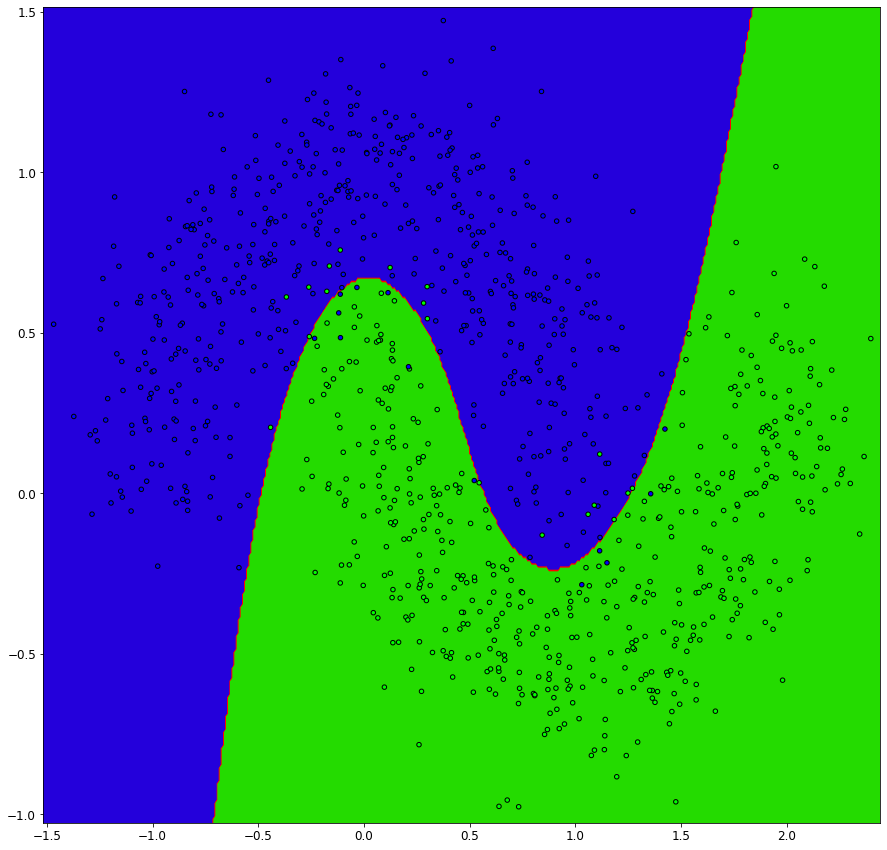

In [ ]:
loss_df = pd.DataFrame(loss_hist)
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

In [ ]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [ ]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)

print('Accruacy score on Train Data :', accuracy_score(y_train, y_pred))

print (confusion_matrix(y_train, y_pred))

Accruacy score on Train Data : 0.9697265625
[[509  13]
 [ 18 484]]


In [ ]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(y_test, y_pred))

print (confusion_matrix(y_test, y_pred))

Accruacy score on Test Data : 0.95703125
[[114   4]
 [  7 131]]


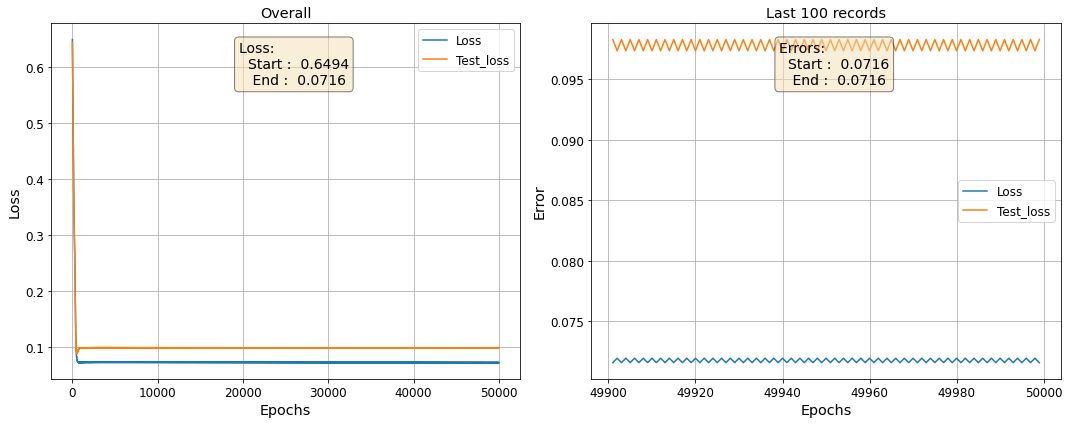

In [ ]:
loss_df = pd.DataFrame(loss_hist)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)
loss = loss_df['Loss'].values

# little beautification
txtstr = "Loss: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = ['Loss', 'Test_loss'], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()

# Story So Far 

    
|#|Implementation|Training Error|Testing Error|Remarks|
|:-:|:--|:-:|:-:|:--|
|1|Simple Perceptron|0.85333|0.90000||
|2|Perceptron including Softmax and Gradient Descent|0.86555|0.90000||
|3|One hidden layer with ${Tanh}$ activation|0.96875|0.960938||
|4|One hidden layer with ${ReLU}$ activation|0.96484|0.957031||
|5|Multiple Hidden Layers|0.97461|0.957031|Training accuracy is still increasing, but testing accuracy is same.
|6|Multiple Hidden Layers with L1 regularization|0.97266|0.957031|Training Accuracy is checked.|
|7|Multiple Hidden Layers with L2 regularization|0.97070|0.960938|Regularization improves both accuracy.|
|8|Multiple Hidden Layers with Dropout|0.96972|0.957031|Regularization improves both accuracy.|
|9|Multiple Hidden Layers with Adam|0.97168|0.960938|Adam helps.|